## Multiple Linear Regression for predicting California housing prices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px 

### Data exploration
This is the dataset used in the second chapter of Aurélien Géron's recent book 'Hands-On Machine learning with Scikit-Learn and TensorFlow'.

About this file
1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

### Here you have 300 houses with color representing their value.




In [2]:
df = pd.read_csv('housing.csv')
fig = px.scatter_geo(df.sample(300), 
                     lat = "latitude", 
                     lon = "longitude",
                     color = 'median_house_value',
                     scope = 'usa')
fig.update_traces(marker=dict(size=10))
fig.show()

### Here you have 300 houses with color representing the categorical data "ocean_proximity".


In [3]:
df = pd.read_csv('housing.csv')
fig = px.scatter_geo(df.sample(300), 
                     lat = "latitude", 
                     lon = "longitude",
                     color = 'ocean_proximity',
                     scope = 'usa')
fig.update_traces(marker=dict(size=10))
fig.show()

### Lets look at one example: 

In [4]:
print('The CSV file contains',len(df),'examples.')
df.head(1)

The CSV file contains 20640 examples.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY


The next line of code helps me localize if any feature has some missing data (NaNs for example). In this case, you can quickly notice how the feature total_bedrooms is missing a few hundred datapoints. This can lead to errors in the model and one must take car of the missing data. 

In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We have 207 rows with at least 1 NaN value:

In [6]:
np.count_nonzero(df.isna())


207

In [7]:
df[df.isna().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


Since the amount of examples containing NaNs is just 1% of the total data we can drop these rows without loosing too much statistical value. 

In [8]:
df = df.dropna();


Before bulding a MLR model one must check that the data is suitable for building this kind of model and making new predictions. The data must have the following features:  

1. Linearity
2. Homoscedacity
3. Multivariate Normality
4. Independence of errors
5. Lack of multicollinearity

### Setting independent and dependent variables

For personal reasons I choose to place the Categorical Data (column 9) at the beginning of my matrix of features. 

In [9]:
X = df.iloc[:, [9,0,1,2,3,4,5,6,7]].to_numpy()

y = df.iloc[:, -2].values
X.shape

(20433, 9)

In [10]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

### Encoding categorical data "Ocean proximity" 

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
print(X)

[[0.0 0.0 0.0 ... 322.0 126.0 8.3252]
 [0.0 0.0 0.0 ... 2401.0 1138.0 8.3014]
 [0.0 0.0 0.0 ... 496.0 177.0 7.2574]
 ...
 [0.0 1.0 0.0 ... 1007.0 433.0 1.7]
 [0.0 1.0 0.0 ... 741.0 349.0 1.8672]
 [0.0 1.0 0.0 ... 1387.0 530.0 2.3886]]


One example of a full feature vector after applying OneHotEncoder. 5 columns are created from the categorical data "Ocean proximity". 

In [12]:
print(X[0])

[0.0 0.0 0.0 1.0 0.0 -122.23 37.88 41.0 880.0 129.0 322.0 126.0 8.3252]


In order to not fall in the dummy-variable trap we can eliminate 1 of the n=5 columns. 

In [13]:
# Avoiding the Dummy Variable Trap
X = X[:, 1:]
print(X[0])

[0.0 0.0 1.0 0.0 -122.23 37.88 41.0 880.0 129.0 322.0 126.0 8.3252]


### Splitting training set and test set 

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Feature Scaling

It is important to understand that the Feature Scaling transformation is defined using the training set. Once defined, we can apply the transformation to both the training set and the test set. 

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#sc.fit_transform computes the mean & std of each column of features 
# (1 through 4 in this case) and transforms the values
X_train[:, 4:] = sc.fit_transform(X_train[:, 4:])
#sc.transform just performs the same previous transformation 
X_test[:, 4:] = sc.transform(X_test[:, 4:])

In [16]:
X_train[26] #one random example to see how FS was performed

array([0.0, 0.0, 0.0, 1.0, -1.4613438889594033, 0.9711188750559547,
       0.5820537475145935, -0.3164212465767392, -0.47079924105536664,
       -0.5243807826500871, -0.4883256591350092, 0.7441674826255378],
      dtype=object)

## Training the Multiple Linear Regression model on the Training set

In [17]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
#We can display the learned coefficients of our Multiple Linear Model
print(regressor.coef_,regressor.intercept_)

[-38268.3749283  168238.3154121   -3963.37829779   3102.65960032
 -55669.46634558 -56082.27704372  13705.17935882 -13021.2323257
  42542.06763686 -40826.80238689  16159.10903931  74334.92049205] 218809.8196091224


## Lets see how it does with the Test set

In [18]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=0)
print('Predicted','Real Value')
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

Predicted Real Value
[[189847.  98900.]
 [175807. 153000.]
 [123403.  91300.]
 ...
 [155110. 127000.]
 [217119. 158600.]
 [250190. 175000.]]


Text(0, 0.5, 'Predicted Value')

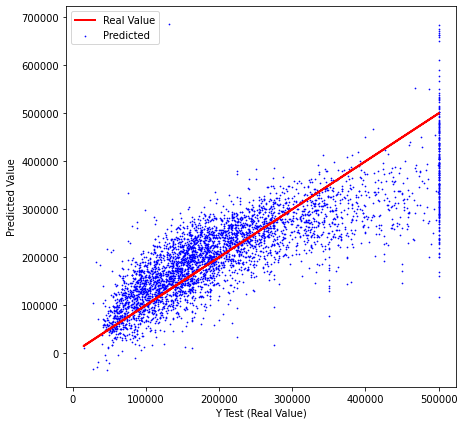

In [21]:
plt.figure(figsize=(7,7))
plt.scatter(y_test,y_pred,color='blue', label='Predicted',s = 0.5)
plt.plot(y_test,y_test,color='red',label='Real Value',lw = 2)
plt.legend()
plt.xlabel('Y Test (Real Value)')
plt.ylabel('Predicted Value')